### To identify various topics from the CORONA-19 based texual data basis following quetions:
Data provided is a resource of over 29,000 scholarly articles, including over 13,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses

Data size is 2 GB and data format is JSON.

##### Competitions is about finding answers to below questions:
 1. What is known about transmission, incubation, and environmental stability? 
 2. What do we know about COVID-19 risk factors?
 3. What do we know about virus genetics, origin, and evolution?
 3. What do we know about vaccines and therapeutics?
 4. What do we know about diagnostics and surveillance?
 5. What do we know about non-pharmaceutical interventions?
 6. What has been published about ethical and social science considerations?
 7. What do we know about virus genetics, origin, and evolution?
 8. What has been published about medical care?
 9. What has been published about information sharing and inter-sectoral collaboration?

##### Business problem to Machine learning problem:
Each of the above question is provided with some more detailed explanation by Kaggle. Finding answers to above questions mean finding most representative documents in the corpus for the above questions' text and finding dominant topic for them. So here NLP technique called "Topic Modelling" is used.It will automate the process of narrowing down the search for the ton & tons of articles.

##### Below is the approach followed for topic modeling:
1. Convert semi-structured JSON to structured data
2. Cleaning the data for emails, newline characters etc
3. Tokenize the documents and clean-up using gensim’s simple_preprocess()
4. Lemmatization
5. Create the Document-Word matrix needed for Topic Modeling
6. Build LDA model with sklearn. LDA’s approach to topic modeling is, it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.
7. Diagnose model performance with perplexity and log-likelihood
8. GridSearch the best LDA model
9. To see the best topic model and its parameters
10. Compare LDA Model Performance Scores
11. To see the dominant topic in each document
12. Review topics distribution across documents
13. Visualize the LDA model with pyLDAvis
14. To see the Topic’s keywords & get the top 15 keywords each topic
15. To predict the topics for a new piece of text
16. To get similar documents for any given piece of text /task

In [132]:
# Run in terminal or command prompt
# python3 -m spacy download en

import numpy as np
import pandas as pd
import glob, json
import re, nltk, spacy, gensim
import os, sys
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint
import pickle
from scipy.spatial.distance import jensenshannon

# Plotting tools
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [96]:
data_root_path = 'C:\\Users\\Abhishek Tanksali\\OneDrive\\AT_DATA\\AT\\Python_Workspace\\HDFC_Bank\\CORD-19\\data\\'
dataout_approach3 = os.path.join(data_root_path,'out\\approach_3\\')

In [6]:
json_filenames = glob.glob(f'{data_root_path}/in/2020-03-13/**/*.json', recursive=True)

In [7]:
len(json_filenames)

13202

In [8]:
def return_corona_df(json_filenames, df):
    for file_name in json_filenames:
        source = file_name.split('\\')[-2]

        row = {"doc_id": None, "source": None, "title": None,
              "abstract": None, "text_body": None}

        with open(file_name) as json_data:
            data = json.load(json_data)

            doc_id = data['paper_id']
            row['doc_id'] = doc_id
            row['title'] = data['metadata']['title'].replace(',', ' ').replace('\n', ' ')
            

            # Now need all of abstract. Put it all in 
            # a list then use str.join() to split it
            # into paragraphs. 

            abstract_list = [abst['text'] for abst in data['abstract']]
            abstract = " ".join(abstract_list)
            abstract = abstract.replace(',', ' ').replace('\n', ' ')
            row['abstract'] = abstract

            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = " ".join(body_list)
            body = body.replace(',', ' ').replace('\n', ' ')
            
            row['text_body'] = body
            
            row['source'] = source
            
            # Add to the dataframe. 

            df = df.append(row, ignore_index=True)
    
    return df

In [11]:
corona_features = {"doc_id": [None], "source": [None], "title": [None],
                  "abstract": [None], "text_body": [None]}
corona_df = pd.DataFrame.from_dict(corona_features)
corona_df = return_corona_df(json_filenames, corona_df)
corona_df = corona_df.dropna().reset_index(drop=True)

In [12]:
corona_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13202 entries, 0 to 13201
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   doc_id     13202 non-null  object
 1   source     13202 non-null  object
 2   title      13202 non-null  object
 3   abstract   13202 non-null  object
 4   text_body  13202 non-null  object
dtypes: object(5)
memory usage: 515.8+ KB


In [13]:
corona_df.head(10)

,doc_id,source,title,abstract,text_body
0,0015023cc06b5362d332b3baf348d11567ca2fbb,biorxiv_medrxiv,The RNA pseudoknots in foot-and-mouth disease ...,word count: 194 22 Text word count: 5168 23 24...,VP3 and VP0 (which is further processed to VP...
1,004f0f8bb66cf446678dc13cf2701feec4f36d76,biorxiv_medrxiv,Healthcare-resource-adjusted vulnerabilities t...,,The 2019-nCoV epidemic has spread across China...
2,00d16927588fb04d4be0e6b269fc02f0d3c2aa7b,biorxiv_medrxiv,Real-time MinION-based amplicon sequencing f...,Infectious bronchitis (IB) causes significant ...,Infectious bronchitis (IB) which is caused by...
3,013d9d1cba8a54d5d3718c229b812d7cf91b6c89,biorxiv_medrxiv,Assessing spread risk of Wuhan novel coronavir...,Background: A novel coronavirus (2019-nCoV) em...,In December 2019 a cluster of patients with p...
4,01d162d7fae6aaba8e6e60e563ef4c2fca7b0e18,biorxiv_medrxiv,TWIRLS an automated topic-wise inference meth...,Faced with the current large-scale public heal...,The sudden outbreak of the new coronavirus (SA...
5,01e3b313e78a352593be2ff64927192af66619b5,biorxiv_medrxiv,Title: Viruses are a dominant driver of protei...,Viruses interact with hundreds to thousands of...,The copyright holder for this preprint (which ...
6,02201e4601ab0eb70b6c26480cf2bfeae2625193,biorxiv_medrxiv,The impact of regular school closure on season...,School closure is often considered as an optio...,they affect seasonal influenza dynamics. The m...
7,0255ea4b2f26a51a3bfa3bd8f3e1978c82c976d5,biorxiv_medrxiv,Carbon Nanocarriers Deliver siRNA to Intact Pl...,Post-transcriptional gene silencing (PTGS) is ...,siRNA without relying on plant transformation ...
8,029c1c588047f1d612a219ee15494d2d19ff7439,biorxiv_medrxiv,Protective Population Behavior Change in Outbr...,,estimation is complicated however by efforts...
9,03ce432f27c7df6af22b92245a614db2ecb5de5f,biorxiv_medrxiv,A hidden gene in astroviruses encodes a cell-p...,Human astroviruses are small nonenveloped viru...,Humans astroviruses (HAstVs) belong to genus M...


In [100]:
#corona_df.to_csv(dataout_approach3+'out/kaggle_covid-19.csv')
corona_df_out = open(dataout_approach3+"corona_df.pickle","wb")
pickle.dump(corona_df, corona_df_out)
corona_df_out.close()

In [14]:
# Remove emails and newline characters
# Convert to list
data = corona_df.text_body.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<>:6: DeprecationWarning: invalid escape sequence \S
<>:9: DeprecationWarning: invalid escape sequence \s
<ipython-input-14-84774f210ea9>:6: DeprecationWarning: invalid escape sequence \S
  data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]
<ipython-input-14-84774f210ea9>:9: DeprecationWarning: invalid escape sequence \s
  data = [re.sub('\s+', ' ', sent) for sent in data]


['VP3 and VP0 (which is further processed to VP2 and VP4 during virus '
 'assembly) (6). The P2 64 and P3 regions encode the non-structural proteins '
 '2B and 2C and 3A 3B (1-3) (VPg) 3C pro and 4 structural protein-coding '
 'region is replaced by reporter genes allow the study of genome 68 '
 'replication without the requirement for high containment (9 10) ( figure 1A '
 '). The FMDV 5′ UTR is the largest known picornavirus UTR comprising '
 'approximately 1300 71 nucleotides and containing several highly structured '
 'regions. The first 360 nucleotides at the 5′ 72 end are predicted to fold '
 'into a single large stem loop termed the S-fragment followed by a The PKs '
 'were originally predicted in 1987 and consist of two to four tandem repeats '
 'of a ~48 86 nucleotide region containing a small stem loop and downstream '
 'interaction site (figure 1B) 87 (12). Due to the sequence similarity between '
 'the PKs (figure 1C) it is speculated that they 88 were formed by duplication

In [15]:
#Tokenize and Clean-up using gensim’s simple_preprocess()
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['vp', 'and', 'vp', 'which', 'is', 'further', 'processed', 'to', 'vp', 'and', 'vp', 'during', 'virus', 'assembly', 'the', 'and', 'regions', 'encode', 'the', 'non', 'structural', 'proteins', 'and', 'and', 'vpg', 'pro', 'and', 'structural', 'protein', 'coding', 'region', 'is', 'replaced', 'by', 'reporter', 'genes', 'allow', 'the', 'study', 'of', 'genome', 'replication', 'without', 'the', 'requirement', 'for', 'high', 'containment', 'figure', 'the', 'fmdv', 'utr', 'is', 'the', 'largest', 'known', 'picornavirus', 'utr', 'comprising', 'approximately', 'nucleotides', 'and', 'containing', 'several', 'highly', 'structured', 'regions', 'the', 'first', 'nucleotides', 'at', 'the', 'end', 'are', 'predicted', 'to', 'fold', 'into', 'single', 'large', 'stem', 'loop', 'termed', 'the', 'fragment', 'followed', 'by', 'the', 'pks', 'were', 'originally', 'predicted', 'in', 'and', 'consist', 'of', 'two', 'to', 'four', 'tandem', 'repeats', 'of', 'nucleotide', 'region', 'containing', 'small', 'stem', 'loop',

In [16]:
# Lemmatization
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 2000000
# Do lemmatization keeping only Noun, Adj, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:2])

['further process virus assembly region encode non structural protein vpg pro structural protein coding region replace reporter gene allow study genome replication requirement high containment figure fmdv utr large know picornavirus utr comprise approximately nucleotide contain several highly structured region first nucleotide end predict fold single large stem loop term fragment follow pks originally predict consist tandem repeat nucleotide region contain small stem loop downstream interaction site figure sequence similarity pks figure speculate form duplication event viral replication probably involve recombination pks present different virus isolate strain identify less pks emphasise potential importance viral life cycle presence report utr other picornavirus such author funder right reserve reuse allow permission can occur absence at least require wild type wt replication furthermore competition experiment show extra copy pks confer replicative advantage genome replicon full length

In [101]:
data_lemmatized_out = open(dataout_approach3+"data_lemmatized.pickle","wb")
pickle.dump(data_lemmatized, data_lemmatized_out)
data_lemmatized_out.close()

In [17]:
# Create the Document-Word matrix
vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}',  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [102]:
data_vectorized_out = open(dataout_approach3+"data_vectorized.pickle","wb")
pickle.dump(data_vectorized, data_vectorized_out)
data_vectorized_out.close()

In [18]:
# Check the Sparsicity
# Materialize the sparse data
data_dense = data_vectorized.todense()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  2.4520277606520215 %


In [20]:
# Build LDA model with sklearn
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attribute

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
                          evaluate_every=-1, learning_decay=0.7,
                          learning_method='online', learning_offset=10.0,
                          max_doc_update_iter=100, max_iter=10,
                          mean_change_tol=0.001, n_components=20, n_jobs=-1,
                          perp_tol=0.1, random_state=100, topic_word_prior=None,
                          total_samples=1000000.0, verbose=0)


In [21]:
# Diagnose model performance with perplexity and log-likelihood
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -181938512.1589659
Perplexity:  1528.1081248029918
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 20,
 'n_jobs': -1,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [22]:
# GridSearch the best LDA model
# Define Search Param
search_params = {'n_components': [8, 12, 16, 20], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

GridSearchCV(cv=None, error_score=nan,
             estimator=LatentDirichletAllocation(batch_size=128,
                                                 doc_topic_prior=None,
                                                 evaluate_every=-1,
                                                 learning_decay=0.7,
                                                 learning_method='batch',
                                                 learning_offset=10.0,
                                                 max_doc_update_iter=100,
                                                 max_iter=10,
                                                 mean_change_tol=0.001,
                                                 n_components=10, n_jobs=None,
                                                 perp_tol=0.1,
                                                 random_state=None,
                                                 topic_word_prior=None,
                                                 tota

In [103]:
model_out = open(dataout_approach3+"model.pickle","wb")
pickle.dump(model, model_out)
model_out.close()

In [23]:
# best topic model and its parameters
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.7, 'n_components': 20}
Best Log Likelihood Score:  -37108584.823726684
Model Perplexity:  1504.2430369256665


In [104]:
best_lda_model_out = open(dataout_approach3+"best_lda_model.pickle","wb")
pickle.dump(best_lda_model, best_lda_model_out)
best_lda_model_out.close()

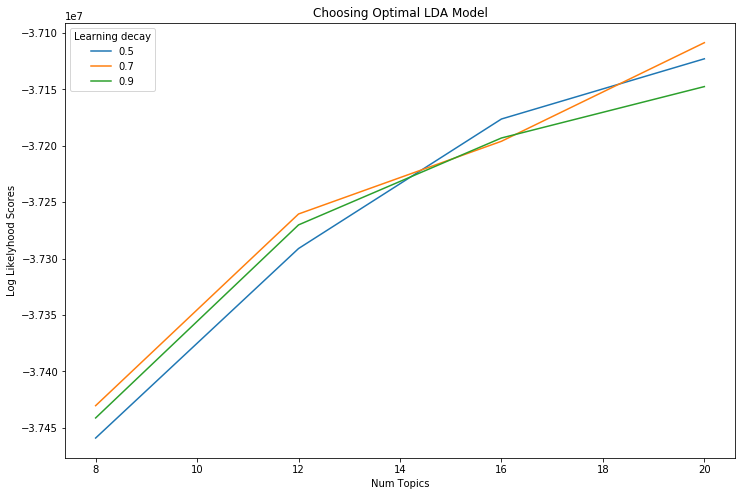

In [118]:
# Compare LDA Model Performance Scores
# Get Log Likelyhoods from Grid Search Output
n_topics = [8, 12, 16, 20]
# log_likelyhoods_5 = [round(gscore.mean_validation_score) for gscore in model.cv_results_['mean_test_score'] if model.cv_results_['param_learning_decay']==0.5]
# log_likelyhoods_7 = [round(gscore.mean_validation_score) for gscore in model.cv_results_['mean_test_score'] if gscore.cv_results_['param_learning_decay']==0.7]
# log_likelyhoods_9 = [round(gscore.mean_validation_score) for gscore in model.cv_results_['mean_test_score'] if gscore.cv_results_['param_learning_decay']==0.9]

log_likelyhoods_5 = model.cv_results_['mean_test_score'][:4]
log_likelyhoods_7 = model.cv_results_['mean_test_score'][4:8]
log_likelyhoods_9 = model.cv_results_['mean_test_score'][8:]
# Show graph
plt.figure(figsize=(12, 8))
plt.plot(n_topics, log_likelyhoods_5, label='0.5')
plt.plot(n_topics, log_likelyhoods_7, label='0.7')
plt.plot(n_topics, log_likelyhoods_9, label='0.9')
plt.title("Choosing Optimal LDA Model")
plt.xlabel("Num Topics")
plt.ylabel("Log Likelyhood Scores")
plt.legend(title='Learning decay', loc='best')
plt.savefig(dataout_approach3+'optimal_lda_model_topics_log_Score.png')
plt.show()

In [36]:
# to see the dominant topic in each document
# Create Document - Topic Matrix
lda_output = best_lda_model.transform(data_vectorized)

# column names
topicnames = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)

def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

# Apply Style
df_document_topics = df_document_topic.head(15).style.applymap(color_green).applymap(make_bold)
df_document_topics


,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,Topic10,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
Doc0,0.000000,0.040000,0.000000,0.000000,0.300000,0.000000,0.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.120000,0.390000,0.000000,0.030000,0.000000,0.000000,0.050000,0.000000,13
Doc1,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,0.470000,0.000000,0.000000,0.000000,0.000000,0.440000,0.000000,0.000000,0.000000,11
Doc2,0.020000,0.000000,0.340000,0.000000,0.130000,0.000000,0.000000,0.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.090000,0.000000,0.370000,0.000000,0.000000,0.000000,0.000000,15
Doc3,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.190000,0.000000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.000000,0.530000,0.000000,0.000000,0.000000,16
Doc4,0.000000,0.000000,0.000000,0.010000,0.270000,0.000000,0.000000,0.000000,0.000000,0.000000,0.450000,0.010000,0.020000,0.000000,0.000000,0.000000,0.000000,0.080000,0.110000,0.050000,10
Doc5,0.000000,0.000000,0.000000,0.000000,0.140000,0.000000,0.000000,0.000000,0.000000,0.000000,0.190000,0.000000,0.340000,0.060000,0.000000,0.140000,0.080000,0.000000,0.060000,0.000000,12
Doc6,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.110000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.860000,0.000000,0.000000,0.000000,16
Doc7,0.000000,0.300000,0.060000,0.000000,0.220000,0.000000,0.080000,0.000000,0.060000,0.190000,0.020000,0.000000,0.000000,0.050000,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,1
Doc8,0.000000,0.000000,0.000000,0.000000,0.030000,0.000000,0.000000,0.070000,0.000000,0.000000,0.000000,0.190000,0.000000,0.000000,0.000000,0.000000,0.710000,0.000000,0.000000,0.000000,16
Doc9,0.000000,0.200000,0.000000,0.000000,0.090000,0.000000,0.000000,0.000000,0.040000,0.000000,0.030000,0.000000,0.040000,0.560000,0.000000,0.020000,0.000000,0.000000,0.020000,0.000000,13


In [122]:
# to see the dominant topic in each document
# Create Document - Topic Matrix
lda_output_n = best_lda_model.transform(data_vectorized)

# column names
topicnames_n = ["Topic" + str(i) for i in range(best_lda_model.n_components)]

# index names
#docnames = ["Doc" + str(i) for i in range(len(data))]

# Make the pandas dataframe
df_document_topic_n = pd.DataFrame(np.round(lda_output_n, 2), columns=topicnames_n)

# Get dominant topic for each document
dominant_topic_n = np.argmax(df_document_topic_n.values, axis=1)
df_document_topic_n['dominant_topic'] = dominant_topic_n
df_document_topic_n.head()

,Topic0,Topic1,Topic2,Topic3,Topic4,Topic5,Topic6,Topic7,Topic8,Topic9,...,Topic11,Topic12,Topic13,Topic14,Topic15,Topic16,Topic17,Topic18,Topic19,dominant_topic
0,0.00,0.04,0.00,0.00,0.30,0.0,0.0,0.00,0.08,0.0,...,0.00,0.12,0.39,0.0,0.03,0.00,0.00,0.05,0.00,13
1,0.00,0.00,0.00,0.00,0.04,0.0,0.0,0.04,0.00,0.0,...,0.47,0.00,0.00,0.0,0.00,0.44,0.00,0.00,0.00,11
2,0.02,0.00,0.34,0.00,0.13,0.0,0.0,0.00,0.00,0.0,...,0.00,0.00,0.09,0.0,0.37,0.00,0.00,0.00,0.00,15
3,0.00,0.00,0.00,0.00,0.20,0.0,0.0,0.19,0.00,0.0,...,0.07,0.00,0.00,0.0,0.00,0.53,0.00,0.00,0.00,16
4,0.00,0.00,0.00,0.01,0.27,0.0,0.0,0.00,0.00,0.0,...,0.01,0.02,0.00,0.0,0.00,0.00,0.08,0.11,0.05,10


In [124]:
df_document_topic_n.to_csv(dataout_approach3+"df_document_topic_n.csv")

In [37]:
# Review topics distribution across documents
df_topic_distribution = df_document_topic['dominant_topic'].value_counts().reset_index(name="Num Documents")
df_topic_distribution.columns = ['Topic Num', 'Num Documents']
df_topic_distribution

,Topic Num,Num Documents
0,7,1393
1,11,1313
2,8,967
3,16,864
4,17,831
5,1,737
6,18,736
7,15,704
8,3,682
9,13,674


In [125]:
df_topic_distribution.to_csv(dataout_approach3+"df_topic_distribution.csv")

In [38]:
# Visualize the LDA model with pyLDAvis
pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=                x           y  topics  cluster      Freq
topic                                                   
11     -10.878068   10.538728       1        1  8.445227
8      -60.884026  -75.591820       2        1  7.452661
18      -2.336119  -53.289074       3        1  6.830779
7      -61.385319  -12.914634       4        1  6.739724
17     -28.737743  126.296997       5        1  6.601560
1        1.066606 -123.552811       6        1  6.453938
16      45.140720   -7.947869       7        1  6.219690
3     -140.795975  -98.530548       8        1  5.214626
10      61.531681  -83.240562       9        1  5.113444
19     -72.563057 -140.396881      10        1  4.913759
12      15.984491   63.578186      11        1  4.656931
13    -160.851624   68.945145      12        1  4.555005
15      85.961830   51.922935      13        1  4.300237
14     -99.020836  109.936348      14        1  4.269010
2     -176.764130   -8.681684      15        1  4.176856
9     -117.189880  -37.420200      16        1  4.025750
5      108.829918  -22.946203      17        1  3.721643
0       47.588097  121.934814      18        1  2.944582
6     -106.467834   30.176889      19        1  2.426293
4      -50.613804   59.328842      20        1  0.938286, topic_info=           Term           Freq          Total Category  logprob  loglift
3025       cell  328745.000000  328745.000000  Default  30.0000  30.0000
15249   patient  113611.000000  113611.000000  Default  29.0000  29.0000
23000     virus  226092.000000  226092.000000  Default  28.0000  28.0000
16920   protein  174945.000000  174945.000000  Default  27.0000  27.0000
19111  sequence   91642.000000   91642.000000  Default  26.0000  26.0000
...         ...            ...            ...      ...      ...      ...
7792        fig    1237.914888   75769.251486  Topic20  -5.2369   0.5546
7799     figure    1242.707577   94811.882844  Topic20  -5.2330   0.3343
5009      datum     928.484723   90490.399195  Topic20  -5.5245   0.0894
22644       use    1084.032061  274598.620629  Topic20  -5.3696  -0.8658
18031    report     891.750100   72643.081431  Topic20  -5.5649   0.2687

[1880 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
1          2  0.945282     aaalac
1         14  0.023056     aaalac
82         1  0.001030  abundance
82         2  0.025747  abundance
82         3  0.182082  abundance
...      ...       ...        ...
23451      1  0.041121        yld
23451      4  0.945792        yld
23452      1  0.033918        yll
23452      4  0.949714        yll
23464     12  0.982420        yyz

[12153 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[12, 9, 19, 8, 18, 2, 17, 4, 11, 20, 13, 14, 16, 15, 3, 10, 6, 1, 7, 5])

In [95]:
pyLDAvis.save_html(panel, os.path.join(dataout_approach3,'covid-19-lda-sklearn_approach3.html'))

In [39]:
# To see the Topic’s keywords
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(best_lda_model.components_)

# Assign Column and Index
df_topic_keywords.columns = vectorizer.get_feature_names()
df_topic_keywords.index = topicnames

# View
df_topic_keywords.head()

,aaa,aaalac,aac,aad,aag,aahl,aap,aas,aav,aavs,...,zoonotically,zoos,zoster,zscore,zsgreen,zwitterionic,zygote,zyme,zymo,zymogen
Topic0,0.050000,0.05,10.088327,0.050000,2.037145,0.05,0.05000,1.140744,0.050000,0.05,...,5.982383,0.05,0.050000,1.08655,0.050000,0.050000,0.05,0.050000,0.050000,0.050000
Topic1,8.479554,0.05,4.811383,9.282790,4.999785,0.05,0.05001,0.050000,11.515233,0.05,...,0.050000,0.05,0.050000,0.05000,16.013419,20.299066,0.05,3.582966,0.050000,26.088663
Topic2,0.050000,0.05,0.050000,6.225885,0.050000,0.05,0.05000,0.050000,0.050000,0.05,...,2.302507,0.05,2.909566,0.05000,0.050000,0.050000,0.05,0.050000,3.378027,0.050000
Topic3,1.241469,0.05,4.128858,0.050000,0.050000,0.05,0.05000,0.050000,0.050000,0.05,...,0.050000,0.05,0.552801,0.05000,0.050000,0.050000,0.05,0.050000,0.050000,0.050000
Topic4,0.050000,0.05,0.050000,0.050000,0.050000,0.05,0.05000,0.050000,0.050000,0.05,...,0.050000,0.05,0.050000,0.05000,0.050000,0.050000,0.05,0.050000,0.050000,0.050000


In [127]:
# Get the top 15 keywords each topic
# Show top n keywords for each topic
def show_topics(vectorizer=vectorizer, lda_model=lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=50)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,...,Word 40,Word 41,Word 42,Word 43,Word 44,Word 45,Word 46,Word 47,Word 48,Word 49
Topic 0,dog,cat,animal,study,disease,infection,sample,bird,report,chicken,...,canine,tissue,year,identify,collect,duck,avian,fecal,blood,presence
Topic 1,cell,protein,fig,use,membrane,figure,contain,fusion,result,particle,...,transfecte,wash,analysis,perform,fraction,complex,formation,plasmid,detect,increase
Topic 2,sample,use,detection,virus,test,detect,positive,assay,viral,primer,...,culture,bacterial,analysis,develop,value,acid,testing,obtain,design,standard
Topic 3,patient,study,use,treatment,clinical,group,day,high,result,include,...,report,score,method,sepsis,infection,failure,test,receive,factor,present
Topic 4,preprint,author,review,copyright,holder,peer,funder,license,make,available,...,increase,observe,associate,cell,epithelium,analysis,suggest,symptom,feature,time
Topic 5,group,study,use,day,level,increase,effect,calf,treatment,significant,...,decrease,total,value,healthy,mean,perform,evaluate,present,report,female
Topic 6,pig,pedv,use,piglet,temperature,sample,particle,virus,water,surface,...,product,collect,measure,transmission,airborne,reduce,table,droplet,day,dry
Topic 7,case,study,patient,infection,year,influenza,respiratory,child,report,age,...,person,care,associate,result,time,clinical,severe,country,month,fever
Topic 8,cell,virus,use,infection,infect,gene,figure,fig,expression,viral,...,detect,tissue,test,previously,express,serum,assay,supernatant,response,line
Topic 9,activity,drug,compound,effect,use,cell,treatment,concentration,inhibit,inhibitor,...,property,effective,addition,lead,protein,resistance,development,human,various,chemical


In [129]:
df_topic_keywords.to_csv(dataout_approach3+"df_topic_keywords.csv")

In [65]:
# To predict the topics for a new piece of text
# Define function to predict topic for a given text document.
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])
nlp.max_length = 2000000

def predict_topic(text, nlp=nlp):
    global sent_to_words
    global lemmatization

    # Step 1: Clean with simple_preprocess
    mytext_2 = list(sent_to_words(text))

    # Step 2: Lemmatize
    mytext_3 = lemmatization(mytext_2, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

    # Step 3: Vectorize transform
    mytext_4 = vectorizer.transform(mytext_3)

    # Step 4: LDA Transform
    topic_probability_scores = best_lda_model.transform(mytext_4)
    topic_keywords = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].values.tolist()
    topic_name = df_topic_keywords.iloc[np.argmax(topic_probability_scores), :].name
    return topic_name, topic_keywords, topic_probability_scores

# Predict the topic
mytext = ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals \
          are contagious, even after recovery. Prevalence of asymptomatic shedding and transmission (e.g., particularly children). Seasonality \
          of transmission. Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental \
          survival to inform decontamination efforts for affected areas and provide information about viral shedding). Persistence and stability \
          on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood). Persistence of virus on surfaces \
          of different materials (e,g., copper, stainless steel, plastic). Natural history of the virus and shedding of it from an infected person \
          Implementation of diagnostics and products to improve clinical processes Disease models, including animal models for infection, disease \
          and transmission Tools and studies to monitor phenotypic change and potential adaptation of the virus Immune response and immunity \
          Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings Effectiveness of \
          personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings Role of \
          the environment in transmission"]
topic_name, topic_keywords, topic_probability_scores = predict_topic(text = mytext)
print(topic_name)
print(topic_keywords)

Topic 19
['virus', 'infection', 'vaccine', 'viral', 'human', 'study', 'response', 'disease', 'respiratory', 'immune', 'influenza', 'rsv', 'animal', 'vaccination', 'cause']


Component's weights: 
 [[ 0.07  0.05  0.14  0.17  0.03  0.06  0.06  0.57  0.09  0.04  0.09  0.7
   0.04  0.08  0.05  0.1   0.26  0.07  0.06  0.13]
 [-0.08 -0.3  -0.18 -0.12 -0.03 -0.08 -0.06 -0.16 -0.43 -0.15 -0.13  0.5
  -0.17 -0.2  -0.15 -0.14 -0.08 -0.31 -0.32 -0.16]]
Perc of Variance Explained: 
 [0.08 0.08]


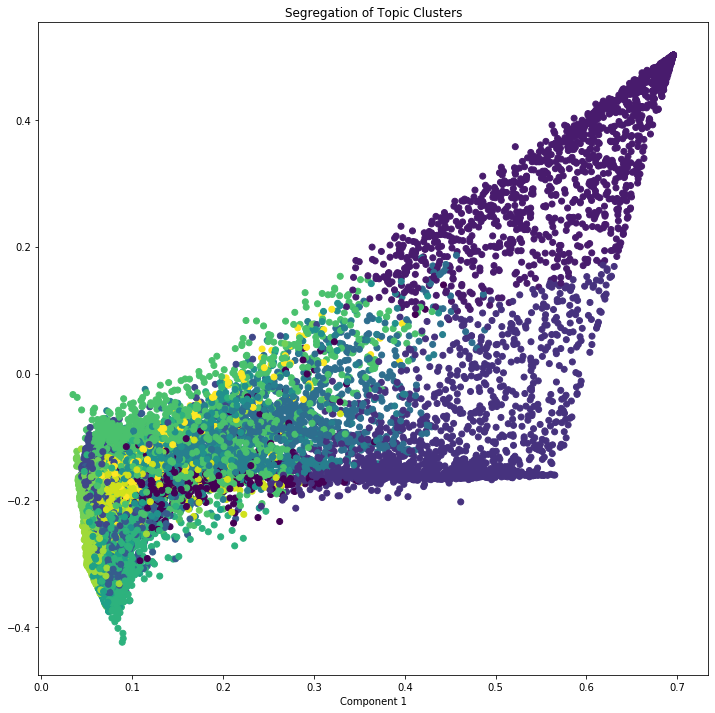

In [130]:
# To cluster documents that share similar topics and plot
# Construct the k-means clusters
from sklearn.cluster import KMeans
clusters = KMeans(n_clusters=15, random_state=100).fit_predict(lda_output)

# Build the Singular Value Decomposition(SVD) model
svd_model = TruncatedSVD(n_components=2)  # 2 components
lda_output_svd = svd_model.fit_transform(lda_output)

# X and Y axes of the plot using SVD decomposition
x = lda_output_svd[:, 0]
y = lda_output_svd[:, 1]

# Weights for the 15 columns of lda_output, for each component
print("Component's weights: \n", np.round(svd_model.components_, 2))

# Percentage of total information in 'lda_output' explained by the two components
print("Perc of Variance Explained: \n", np.round(svd_model.explained_variance_ratio_, 2))

# Plot
plt.figure(figsize=(12, 12))
plt.scatter(x, y, c=clusters)
plt.xlabel('Component 2')
plt.xlabel('Component 1')
plt.title("Segregation of Topic Clusters", )
plt.savefig(dataout_approach3+'Segregation_of_Topic_Clusters.png')

In [69]:
#Get "Nearest" Papers (in Topic Space)
def get_k_nearest_docs(doc_dist, k=5, lower=1950, upper=2020, only_covid19=False):
    '''
    doc_dist: topic distribution (sums to 1) of one article
    
    Returns the index of the k nearest articles (as by Jensen–Shannon divergence in topic space). 
    '''
    
    #relevant_time = df.publish_year.between(lower, upper)
    
    if only_covid19:
        is_covid19_article = corona_df.text_body.str.contains('COVID-19|SARS-CoV-2|2019-nCov|SARS Coronavirus 2|2019 Novel Coronavirus')
        #topic_dist_temp = topic_dist[relevant_time & is_covid19_article]
        topic_dist_temp = topic_dist[is_covid19_article]

        
    else:
        #topic_dist_temp = topic_dist[relevant_time]
        topic_dist_temp = topic_dist

         
    distances = topic_dist_temp.apply(lambda x: jensenshannon(x, doc_dist), axis=1)
    k_nearest = distances[distances != 0].nsmallest(n=k).index
        
    return k_nearest
def relevant_articles(tasks, k=3, lower=1950, upper=2020, only_covid19=False):
    tasks = [tasks] if type(tasks) is str else tasks 
    
    tasks_tf = vectorizer.transform(tasks)
    tasks_topic_dist = pd.DataFrame(best_lda_model.transform(tasks_tf))

    for index, bullet in enumerate(tasks):
        print(bullet)
        recommended = get_k_nearest_docs(tasks_topic_dist.iloc[index], k, lower, upper, only_covid19)
        recommended = corona_df.iloc[recommended]
        return recommended

In [70]:
task1 = ["Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.",
"Prevalence of asymptomatic shedding and transmission (e.g., particularly children).",
"Seasonality of transmission.",
"Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).",
"Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).",
"Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).",
"Natural history of the virus and shedding of it from an infected person",
"Implementation of diagnostics and products to improve clinical processes",
"Disease models, including animal models for infection, disease and transmission",
"Tools and studies to monitor phenotypic change and potential adaptation of the virus",
"Immune response and immunity",
"Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings",
 "Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings",
"Role of the environment in transmission"]

task2 = ['Data on potential risks factors',
'Smoking, pre-existing pulmonary disease',
'Co-infections (determine whether co-existing respiratory/viral infections make the virus more transmissible or virulent) and other co-morbidities',
'Neonates and pregnant women',
'Socio-economic and behavioral factors to understand the economic impact of the virus and whether there were differences.',
'Transmission dynamics of the virus, including the basic reproductive number, incubation period, serial interval, modes of transmission and environmental factors', 
'Severity of disease, including risk of fatality among symptomatic hospitalized patients, and high-risk patient groups',
'Susceptibility of populations',
'Public health mitigation measures that could be effective for control']

task3 = ['Real-time tracking of whole genomes and a mechanism for coordinating the rapid dissemination of that information to inform the development of diagnostics and therapeutics and to track variations of the virus over time.',
'Access to geographic and temporal diverse sample sets to understand geographic distribution and genomic differences, and determine whether there is more than one strain in circulation. Multi-lateral agreements such as the Nagoya Protocol could be leveraged.',
'Evidence that livestock could be infected (e.g., field surveillance, genetic sequencing, receptor binding) and serve as a reservoir after the epidemic appears to be over.',
'Evidence of whether farmers are infected, and whether farmers could have played a role in the origin.',
'Surveillance of mixed wildlife- livestock farms for SARS-CoV-2 and other coronaviruses in Southeast Asia.',
'Experimental infections to test host range for this pathogen.',
'Animal host(s) and any evidence of continued spill-over to humans',
'Socioeconomic and behavioral risk factors for this spill-over',
'Sustainable risk reduction strategies']

task4 = ["Guidance on ways to scale up NPIs in a more coordinated way (e.g., establish funding, infrastructure and authorities to support real time, authoritative (qualified participants) collaboration with all states to gain consensus on consistent guidance and to mobilize resources to geographic areas where critical shortfalls are identified) to give us time to enhance our health care delivery system capacity to respond to an increase in cases.",
"Rapid design and execution of experiments to examine and compare NPIs currently being implemented. DHS Centers for Excellence could potentially be leveraged to conduct these experiments.",
"Rapid assessment of the likely efficacy of school closures, travel bans, bans on mass gatherings of various sizes, and other social distancing approaches.",
"Methods to control the spread in communities, barriers to compliance and how these vary among different populations..",
"Models of potential interventions to predict costs and benefits that take account of such factors as race, income, disability, age, geographic location, immigration status, housing status, employment status, and health insurance status.",
"Policy changes necessary to enable the compliance of individuals with limited resources and the underserved with NPIs.",
"Research on why people fail to comply with public health advice, even if they want to do so (e.g., social or financial costs may be too high).",
"Research on the economic impact of this or any pandemic. This would include identifying policy and programmatic alternatives that lessen/mitigate risks to critical government services, food distribution and supplies, access to critical household supplies, and access to health diagnoses, treatment, and needed care, regardless of ability to pay."]

task5 = ["Effectiveness of drugs being developed and tried to treat COVID-19 patients. Clinical and bench trials to investigate less common viral inhibitors against COVID-19 such as naproxen, clarithromycin, and minocyclinethat that may exert effects on viral replication.",
"Methods evaluating potential complication of Antibody-Dependent Enhancement (ADE) in vaccine recipients.",
"Exploration of use of best animal models and their predictive value for a human vaccine.",
"Capabilities to discover a therapeutic (not vaccine) for the disease, and clinical effectiveness studies to discover therapeutics, to include antiviral agents.",
"Alternative models to aid decision makers in determining how to prioritize and distribute scarce, newly proven therapeutics as production ramps up. This could include identifying approaches for expanding production capacity to ensure equitable and timely distribution to populations in need.",
"Efforts targeted at a universal coronavirus vaccine.",
"Efforts to develop animal models and standardize challenge studies",
"Efforts to develop prophylaxis clinical studies and prioritize in healthcare workers",
"Approaches to evaluate risk for enhanced disease after vaccination",
"Assays to evaluate vaccine immune response and process development for vaccines, alongside suitable animal models [in conjunction with therapeutics]"]

task6 = ["Efforts to articulate and translate existing ethical principles and standards to salient issues in COVID-2019", 
"Efforts to embed ethics across all thematic areas, engage with novel ethical issues that arise and coordinate to minimize duplication of oversight",
"Efforts to support sustained education, access, and capacity building in the area of ethics",
"Efforts to establish a team at WHO that will be integrated within multidisciplinary research and operational platforms and that will connect with existing and expanded global networks of social sciences.",
"Efforts to develop qualitative assessment frameworks to systematically collect information related to local barriers and enablers for the uptake and adherence to public health measures for prevention and control. This includes the rapid identification of the secondary impacts of these measures. (e.g. use of surgical masks, modification of health seeking behaviors for SRH, school closures)",
"Efforts to identify how the burden of responding to the outbreak and implementing public health measures affects the physical and psychological health of those providing care for Covid-19 patients and identify the immediate needs that must be addressed.",
"Efforts to identify the underlying drivers of fear, anxiety and stigma that fuel misinformation and rumor, particularly through social media."]

task7 = ["How widespread current exposure is to be able to make immediate policy recommendations on mitigation measures. Denominators for testing and a mechanism for rapidly sharing that information, including demographics, to the extent possible. Sampling methods to determine asymptomatic disease (e.g., use of serosurveys (such as convalescent samples) and early detection of disease (e.g., use of screening of neutralizing antibodies such as ELISAs).",
"Efforts to increase capacity on existing diagnostic platforms and tap into existing surveillance platforms.",
"Recruitment, support, and coordination of local expertise and capacity (public, private—commercial, and non-profit, including academic), including legal, ethical, communications, and operational issues.",
"National guidance and guidelines about best practices to states (e.g., how states might leverage universities and private laboratories for testing purposes, communications to public health officials and the public).",
"Development of a point-of-care test (like a rapid influenza test) and rapid bed-side tests, recognizing the tradeoffs between speed, accessibility, and accuracy.",
"Rapid design and execution of targeted surveillance experiments calling for all potential testers using PCR in a defined area to start testing and report to a specific entity. These experiments could aid in collecting longitudinal samples, which are critical to understanding the impact of ad hoc local interventions (which also need to be recorded).",
"Separation of assay development issues from instruments, and the role of the private sector to help quickly migrate assays onto those devices.",
"Efforts to track the evolution of the virus (i.e., genetic drift or mutations) and avoid locking into specific reagents and surveillance/detection schemes.",
"Latency issues and when there is sufficient viral load to detect the pathogen, and understanding of what is needed in terms of biological and environmental sampling.",
"Use of diagnostics such as host response markers (e.g., cytokines) to detect early disease or predict severe disease progression, which would be important to understanding best clinical practice and efficacy of therapeutic interventions.",
"Policies and protocols for screening and testing.",
"Policies to mitigate the effects on supplies associated with mass testing, including swabs and reagents.",
"Technology roadmap for diagnostics.",
"Barriers to developing and scaling up new diagnostic tests (e.g., market forces), how future coalition and accelerator models (e.g., Coalition for Epidemic Preparedness Innovations) could provide critical funding for diagnostics, and opportunities for a streamlined regulatory environment.",
"New platforms and technology (e.g., CRISPR) to improve response times and employ more holistic approaches to COVID-19 and future diseases.",
"Coupling genomics and diagnostic testing on a large scale.",
"Enhance capabilities for rapid sequencing and bioinformatics to target regions of the genome that will allow specificity for a particular variant.",
"Enhance capacity (people, technology, data) for sequencing with advanced analytics for unknown pathogens, and explore capabilities for distinguishing naturally-occurring pathogens from intentional.",
"One Health surveillance of humans and potential sources of future spillover or ongoing exposure for this organism and future pathogens, including both evolutionary hosts (e.g., bats) and transmission hosts (e.g., heavily trafficked and farmed wildlife and domestic food and companion species), inclusive of environmental, demographic, and occupational risk factors."]

task8 = ["Resources to support skilled nursing facilities and long term care facilities.",
"Mobilization of surge medical staff to address shortages in overwhelmed communities",
"Age-adjusted mortality data for Acute Respiratory Distress Syndrome (ARDS) with/without other organ failure – particularly for viral etiologies",
"Extracorporeal membrane oxygenation (ECMO) outcomes data of COVID-19 patients",
"Outcomes data for COVID-19 after mechanical ventilation adjusted for age.",
"Knowledge of the frequency, manifestations, and course of extrapulmonary manifestations of COVID-19, including, but not limited to, possible cardiomyopathy and cardiac arrest.",
"Application of regulatory standards (e.g., EUA, CLIA) and ability to adapt care to crisis standards of care level.",
"Approaches for encouraging and facilitating the production of elastomeric respirators, which can save thousands of N95 masks.",
"Best telemedicine practices, barriers and faciitators, and specific actions to remove/expand them within and across state boundaries.",
"Guidance on the simple things people can do at home to take care of sick people and manage disease.",
"Oral medications that might potentially work.",
"Use of AI in real-time health care delivery to evaluate interventions, risk factors, and outcomes in a way that could not be done manually.",
"Best practices and critical challenges and innovative solutions and technologies in hospital flow and organization, workforce protection, workforce allocation, community-based support resources, payment, and supply chain management to enhance capacity, efficiency, and outcomes.",
"Efforts to define the natural history of disease to inform clinical care, public health interventions, infection prevention control, transmission, and clinical trials",
"Efforts to develop a core clinical outcome set to maximize usability of data across a range of trials",
"Efforts to determine adjunctive and supportive interventions that can improve the clinical outcomes of infected patients (e.g. steroids, high flow oxygen)"]

task9 = ["Methods for coordinating data-gathering with standardized nomenclature.",
"Sharing response information among planners, providers, and others.",
"Understanding and mitigating barriers to information-sharing.",
"How to recruit, support, and coordinate local (non-Federal) expertise and capacity relevant to public health emergency response (public, private, commercial and non-profit, including academic).",
"Integration of federal/state/local public health surveillance systems.",
"Value of investments in baseline public health response infrastructure preparedness",
"Modes of communicating with target high-risk populations (elderly, health care workers).",
"Risk communication and guidelines that are easy to understand and follow (include targeting at risk populations’ families too).",
"Communication that indicates potential risk of disease to all population groups.",
"Misunderstanding around containment and mitigation.",
"Action plan to mitigate gaps and problems of inequity in the Nation’s public health capability, capacity, and funding to ensure all citizens in need are supported and can access information, surveillance, and treatment.",
"Measures to reach marginalized and disadvantaged populations.",
"Data systems and research priorities and agendas incorporate attention to the needs and circumstances of disadvantaged populations and underrepresented minorities.",
"Mitigating threats to incarcerated people from COVID-19, assuring access to information, prevention, diagnosis, and treatment.",
"Understanding coverage policies (barriers and opportunities) related to testing, treatment, and care"]

In [82]:
#topic_dist = df_document_topic.iloc[:,:df_document_topic.shape[1]-1]
topic_dist = pd.DataFrame(lda_output)

In [83]:
topic_dist.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.000067,0.038133,0.000067,0.000067,0.302077,0.000067,0.000067,0.000067,0.075685,0.000067,0.000067,0.000067,0.115957,0.393108,0.000067,0.025899,0.000067,0.000067,0.048273,0.000067
1,0.000151,0.000151,0.000151,0.000151,0.044351,0.000151,0.000151,0.042715,0.000151,0.000151,0.000151,0.473423,0.000151,0.000151,0.000151,0.000151,0.437101,0.000151,0.000151,0.000151
2,0.019535,0.000028,0.341544,0.000028,0.132675,0.000028,0.000028,0.000028,0.000028,0.000028,0.042366,0.000028,0.000028,0.091406,0.000028,0.368748,0.000028,0.000028,0.000028,0.003362
3,0.000025,0.000025,0.000025,0.000025,0.199691,0.000025,0.000025,0.192152,0.000025,0.000025,0.000025,0.073476,0.000025,0.000025,0.000025,0.000025,0.534276,0.000025,0.000025,0.000025
4,0.000025,0.000025,0.000025,0.013740,0.267568,0.000025,0.000025,0.000025,0.000025,0.000025,0.453164,0.008173,0.022317,0.000025,0.000025,0.000025,0.000025,0.077445,0.107193,0.050105


In [131]:
topic_dist.to_csv(dataout_approach3+"topic_dist.csv")

In [86]:
# What is known about transmission, incubation, and environmental stability?
task1_rel_art = relevant_articles(task1, 5, only_covid19=True)

Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.


In [87]:
task1_rel_art.head()

,doc_id,source,title,abstract,text_body
5188,7af7848a33dc0c6599e902e9c155ab68fa72ffad,comm_use_subset,Clinical Medicine Communicating the Risk of De...,To understand the severity of infection for a ...,The novel coronavirus disease that appeared in...
11191,b36310af655a9ba95c32c0d8e88e5fb445edb7a1,noncomm_use_subset,-NC-ND license (http://creativecommons.org/lic...,An outbreak of COVID-19 developed aboard the P...,While the novel coronavirus (Covid-19) spread ...
1928,210a892deb1c61577f6fba58505fd65356ce6636,comm_use_subset,Clinical Medicine Incubation Period and Other ...,The geographic spread of 2019 novel coronaviru...,As of 31 January 2020 mainland China reported...
6748,a70e7c4d8ee484ce956e91c8700d0c9310bbdbbc,comm_use_subset,Estimated effectiveness of symptom and risk sc...,Traveller screening is being used to limit fur...,As of February 20 2020 the 2019 novel corona...
308,6445688d3f59cb7e02f2a8b28450cdf118a8a373,biorxiv_medrxiv,Contacts in context: large-scale setting-speci...,Social mixing patterns are crucial in driving ...,For directly transmitted respiratory pathogens...
